# Man-in-the-Middle Attacks on MQTT-based IoT Using BERT Based Adversarial Message Generation

Welcome to my Google Colab for my paper on attacking MQTT-based IoT devices using a GAN inspired message generation using BERT. The purpose of this code is to generate malicious messages based on what is passed in.

**Warning**: This entire program may take some time to process.

## Dependencies

In [1]:
!pip install transformers

In [2]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [3]:
!pip install paho-mqtt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 2.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import torch
import transformers as ppb
import nltk
nltk.download("popular")
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [5]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

BROKER

CLIENT CALLBACKS

ADVERSERIAL MESSAGE GENERATOR

PUBLISHER

SUBSCRIBER

## Function Definitions

In [6]:
#Generator Function for Non-Numeric Words
#X is a pandas Series of a sentence
#gamma is the number of iterations
#returns a series of modified messages (might be modified)
def generatorWords(X,gamma):

  fakeX = []

  if len(X.unique()) < len(X)/2: #if the number of unique values is less than half of the set
    uniqueVals = X.unique()
    fakeX = []
    for i in range(len(X)):
      fakeX.append(random.choice(uniqueVals))
  else:
    for index, value in X.items():
      words = value.split(" ")
      adjs = []
      choosenWord = ""
      pos_all = dict()
      antonyms = []

      #priortize adjectives
      for w in words:
        #print(w)
        pos_l = set()
        for tmp in wn.synsets(w):
            if tmp.name().split('.')[0] == w:
                pos_l.add(tmp.pos())
        pos_all[w] = pos_l

      #in the list of word classes we single out the adjectives
      for a in pos_all:
        if "a" in pos_all[a]:
          adjs.append(a)

      #here we choose which word to flip
      if adjs:
        choosenWord = adjs[0] if len(adjs) > 1 else adjs[0]
      else:
        choosenWord = words[0] if len(words) > 1 else words[0]

      #find antonyms of the choosen word
      for syn in wordnet.synsets(choosenWord):
        for lm in syn.lemmas():
            if lm.antonyms():
                antonyms.append(lm.antonyms()[0].name())
      if antonyms:
        new = [antonyms[gamma] if x==choosenWord else x for x in words]
      else:
        new = [x if x==choosenWord else x for x in words]
      fakeX.append(" ".join(new))
  return pd.Series(fakeX)


In [7]:
#Generator Function For Numeric Data Points
#X is a series of numbers
def generatorNum(X,gamma):
  xHat = np.mean(X)
  sx = np.std(X)
  randomUpper = (xHat) + (sx * gamma)
  randomLower = (xHat) - (sx * gamma)
  beta = []
  for i in range(int(len(X))):
      beta.append(random.randrange(int(randomLower),int(randomUpper)))
  beta = list(map(str, beta))
  #print(beta)
  return pd.Series(beta)

In [8]:
#Generator That Points Data Into The Right Generator
#Returns an dataframe that contains fake data and real data, each with labels 0
#  being real and 1 being false
def generator(df,gamma):
  mDF = df.copy()
  mDF["temperature"] = generatorNum(df["temperature"],gamma)
  mDF["outlook"] = generatorWords(df["outlook"],0)
  mDF["wind"] = generatorWords(df["wind"],0)
  mDF["humidity"] = generatorNum(df["humidity"],gamma)
  fakeData = addLabel(makeSentence(mDF),1) #column 0 is sentences, column 1 is label
  realData = addLabel(makeSentence(df),0)  #Label 0 means data, label 1 means fake data
  return(pd.concat([fakeData,realData],axis=0),fakeData)

In [9]:
#Merges All DataFrame Columns Into A Single Sentence
#Returns a series of the merged DataFrame columns
def makeSentence(df):
  #df is a data frame
  df = df.copy().applymap(str)
  seriesA = df[df.columns[0:]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
  return seriesA

In [10]:
#Adds a label columns to series for classification
#Returns dataframe of two columns, the series and the labels
def addLabel(series,label):
  #takes in a pandas series and a label
  #returns a dataframe
  labels = []
  [labels.append(label) for i in range(len(series))]
  labels = pd.Series(labels)
  return pd.concat([series,labels],axis=1)

In [11]:
#Discriminiator for deteremining whether data is malicious or not
#Returns new gamma, other parameters are for testing and graphing purposes
def discriminator(X, gamma, rho):
  #takes in dataframe in BERT format of sentence and label
  #returns a new gamme to generate data with
  score,indexes,fn,total = BERT(X)
  print("score: " + str(score))
  #if 0.35 < score < 0.55:
  ##  return None
  #else:
  return (score,gamma + rho,indexes,fn,total)

In [12]:
def BERT(df):
  #df is a dataframe containing sentences and labels
  #BERT returns a accruacy and indexes of false negatives

  #tokenize
  tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #pad
  attention_mask = np.where(padded != 0, 1, 0)                            #apply masks
  input_ids = torch.tensor(padded)
  attention_mask = torch.tensor(attention_mask)                           #put masks through torch tensor

  #run through bert
  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)
  features = last_hidden_states[0][:,0,:].numpy()
  labels = df[1]
  return(regression(features,labels))

In [13]:
#Takes BERT pretrained output and put's it through a multi-  layer perceptron
#Returns accuracy and indexes of false negatives
def regression(features,labels):
  train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
  #lr_clf = LogisticRegression(max_iter=500)
  #lr_clf.fit(train_features, train_labels)
  #return(lr_clf.score(test_features, test_labels))
  NeuralNetwork = MLPClassifier(solver='adam', activation="logistic", random_state=1,max_iter=5000)
  NeuralNetwork.fit(train_features, train_labels)
  y2 = NeuralNetwork.predict(test_features)
  y2 = pd.Series(NeuralNetwork.predict(test_features))
  #print(test_labels)
  i=0
  indexes = []
  for index, value in test_labels.items():
    if value == 1:
      if y2[i] == 0:
        indexes.append(index)
    i+=1
  #print(indexes)
  tn, fp, fn, tp = confusion_matrix(test_labels, y2).ravel()
  #fp = confusion_matrix(test_labels, y2)[0][1]
  total = len(test_labels)
  return (NeuralNetwork.score(test_features,test_labels),indexes,fn,total)

In [14]:
def indexToEntry(X,indexes):
  #finds list of indexes in X and returns a dataframe with the entries
  entries = []
  for i in indexes:
    entries.append(X.iloc[i])
  return(pd.DataFrame(entries))

In [15]:
def logisticRegression(train_features, test_features, train_labels, test_labels):
  lr_clf = LogisticRegression(max_iter=500)
  lr_clf.fit(train_features, train_labels)
  #print(lr_clf.score(test_features, test_labels))
  y_pred = lr_clf.predict(test_features)
  score = lr_clf.score(test_features, test_labels)
  tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
  return(fn,score)

In [16]:
def RandomForest(train_features, test_features, train_labels, test_labels):
  RandForest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
  RandForest.fit(train_features, train_labels)
  forest_pred = RandForest.predict(test_features)
  score = RandForest.score(test_features,test_labels)
  tn, fp, fn, tp = confusion_matrix(test_labels, forest_pred).ravel()
  return(fn,score)


In [17]:
def KNN(train_features, test_features, train_labels, test_labels):
  #K Nearest Neighbor With Optimal Neighbor (1)
  knn = KNeighborsClassifier(n_neighbors = 1)
  knn.fit(train_features,train_labels)
  score = knn.score(test_features, test_labels)
  y_pred = knn.predict(test_features)
  tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
  #print(confusion_matrix(test_labels, y_pred))
  #print(classification_report(y_test, y_pred))
  return(fn,score)

In [18]:
def MLP(train_features, test_features, train_labels, test_labels):
  NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
  NeuralNetwork.fit(train_features, train_labels)
  nn_pred = NeuralNetwork.predict(test_features)
  score = NeuralNetwork.score(test_features,test_labels)
  #print(confusion_matrix(test_labels, nn_pred))
  tn, fp, fn, tp = confusion_matrix(test_labels, nn_pred).ravel()
  return(fn,score)

In [19]:
def SVM(train_features, test_features, train_labels, test_labels):
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf.fit(train_features,train_labels)
  svmPred = clf.predict(test_features)
  score = clf.score(test_features,test_labels)
  #print(confusion_matrix(test_labels, pred))
  tn, fp, fn, tp = confusion_matrix(test_labels, svmPred).ravel()
  return(fn,score)

In [20]:
def tests(df,mDF):
  ogData = addLabel(makeSentence(df),0)
  testData = pd.concat([ogData,mDF])
  tokenized = testData[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  train_features, test_features, train_labels, test_labels = train_test_split(padded, testData[1], random_state=42)
  lrFN,lrScore = logisticRegression(train_features, test_features, train_labels, test_labels)
  rfFN,rfScore = RandomForest(train_features, test_features, train_labels, test_labels)
  knnFN,knnScore = KNN(train_features, test_features, train_labels, test_labels)
  mlpFN,mlpScore = MLP(train_features, test_features, train_labels, test_labels)
  svmFN,svmScore = SVM(train_features, test_features, train_labels, test_labels)
  #print("test_labels: " + str(len(test_labels)))
  return(lrFN,lrScore,rfFN,rfScore,knnFN,knnScore,mlpFN,mlpScore,svmFN,svmScore)

SIMULATION

Loaded weather sample data from CSV.
Original Message: {'temperature': 47, 'outlook': 'severe_thunderstorm', 'wind': 'S', 'humidity': 66}
Generated Adversarial Message: 51,rain,S,19


<ipython-input-9-c04302f05e20>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
<ipython-input-9-c04302f05e20>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.712


<ipython-input-9-c04302f05e20>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


Logistic Regression Score: 0.42, Random Forest Score: 0.528
KNN Score: 0.52, MLP Score: 0.516, SVM Score: 0.452


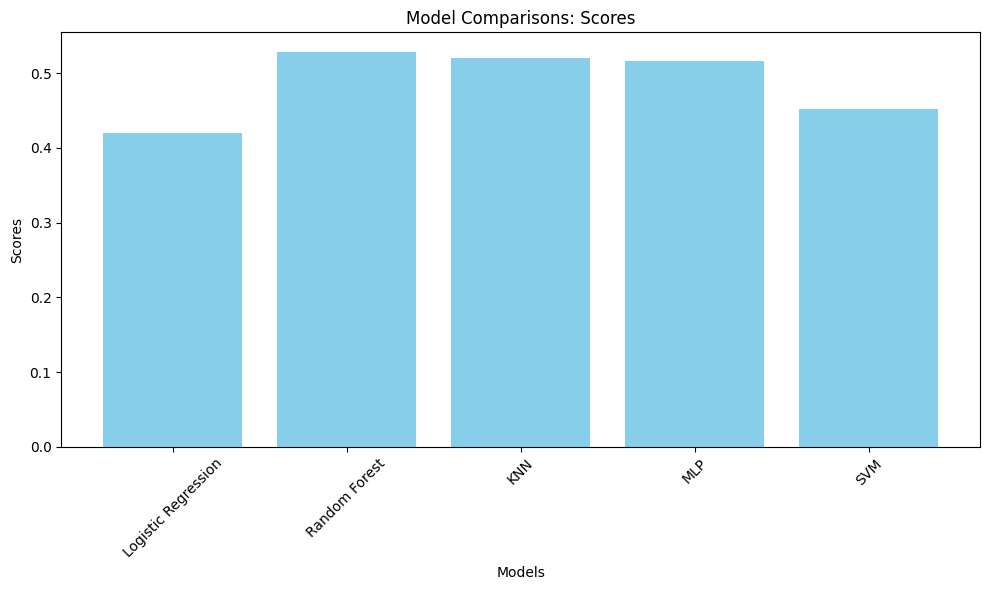

In [23]:
if __name__ == "__main__":
    df = pd.read_csv('https://raw.githubusercontent.com/HenryCWong/adversarialBERTMessages/master/weather_sample_data.csv', delimiter=',')
    df.drop("Unnamed: 0", axis=1, inplace=True)
    print("Loaded weather sample data from CSV.")

    for index, row in df.iterrows():
        original_message = row.to_dict()
    print(f"Original Message: {original_message}")

    gamma = 1
    X, mDF = generator(df, gamma)
    adversarial_message = mDF.iloc[0][0]
    print(f"Generated Adversarial Message: {adversarial_message}")
    score, gamma, indexes, fn, total = discriminator(X, gamma, 1)
    lrFN, lrScore, rfFN, rfScore, knnFN, knnScore, mlpFN, mlpScore, svmFN, svmScore = tests(df, mDF)

    print(f"Logistic Regression Score: {lrScore}, Random Forest Score: {rfScore}")
    print(f"KNN Score: {knnScore}, MLP Score: {mlpScore}, SVM Score: {svmScore}")

    model_scores = {
        'Logistic Regression': lrScore,
        'Random Forest': rfScore,
        'KNN': knnScore,
        'MLP': mlpScore,
        'SVM': svmScore
    }


    plt.figure(figsize=(10, 6))
    plt.bar(model_scores.keys(), model_scores.values(), color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Model Comparisons')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()